# Starting of the program

## Imports and functions

In [22]:
#Import all the librairies

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.spatial

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import sys
import os
import traceback
import optparse
import time
import logging
import math as m
import seaborn as sns
import cv2 
from google.colab.patches import cv2_imshow

ModuleNotFoundError: No module named 'google.colab'

In [14]:
def orientationDet(a, b, c):
    """
    
    Input:
       a,b,c : three 2D points represented by array
    Output:
        float
    return the orientation determinant of the points in the
    order a,b,c
    
    """
    res = (b[0] - a[0]) * (c[1] - b[1]) - (c[0] - b[0]) * (b[1] - a[1])
    return res


def inter_colineaire(a, b, c, d):
    """
    Input:
       a,b,c,d : four 2D points represented by array
       
    Check when the segment [a,b] intersect the
    segment [c,d] if the two are colinear

    if all the vector between the two segments have
    the same sign return false"""
    dot1 = np.dot(d-a, d-b)
    dot2 = np.dot(c-a, c-b)
    dot3 = np.dot(a-c,a-d)
    
    if (dot1 == 0 or dot2 == 0 or dot3 == 0):
        return true

    if (
    dot1 < 0 or dot2 <0 or dot3 <0
    ):
        return True
    else:
        return False

def segment_segment(a, b, c, d,check_colinear) :
    """
    Check if the segment [a,b] intersect the
    segment [c,d]
    Input:
    
    check_colinear: indicate if we need to check to case where the segments are
              colinear

    """
    if(check_colinear):
        if (orientationDet(a, b, c) == 0 and orientationDet(a, b, d) == 0):
            return inter_colineaire(a, b, c, d)
        else:
            return False
    if (line_segment(a, b, c, d) and line_segment(c, d, a, b)):
        return True
    return False

def line_segment(a, b, c, d):
    """
    return:
        boolean
        
    Check if line a,b intersect [c,d]
    """
    res1 = orientationDet(a, b, c)
    res2 = orientationDet(a, b, d)
    if (res1 == 0 or res2 == 0):
        return True
    elif (np.sign(res1) != np.sign(res2)):
        return True
    else:
        return False
    
def ray_segment(a, b, c, d,check_colinear):
    """
    Check if semi-line from a with direction b
    intersect [c,d]
    
    Input:
    
    check_colinear: indicate if we need to check to case where the segments are
              colinear
              
    """

    aplusb = a+b
    ac = c-a
    ad = d-a

    #Check if the line c,d is colinear with [a,a+b]
    if(check_colinear):
        if (
        orientationDet(a, aplusb, c) == 0 and
        orientationDet(a, aplusb, d) == 0
        ):
            if( (ac/aplusb)[0]>0 or (ad/aplusb)[0]>0 ):
                return True
            else:
                return False
    
    if (line_segment(a, aplusb, c, d)):
        #Regarde si la droite c,d touche la demi droite
        #partant de a et de direction b
        #On cherche à créer un large segment
        b_unit = np.array([b[0] / np.linalg.norm(b), b[1] / np.linalg.norm(b)])
        mult = max(np.dot(ac, b_unit), np.dot(ad, b_unit))
        limit = a+b_unit*mult

        if (mult < 0):
            return False

        #si mult = 0 il y a un point sur la perpendiculaire de b au point a.
        if (mult == 0):
            if (np.dot(ac, b_unit) == np.dot(ad, b_unit)):
                return True
            else:
                return False

        if (line_segment(c, d, a, limit)):
            return True
    return False

In [15]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    '''Done by: http://www.noah.org/wiki/Wavelength_to_RGB_in_Python'''
    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R, G, B)

class k_means_solver():
    """
    Class to compute the k-means of a set of points L with given
    initials centers M. 
    
    The program also given an interactive interface using voronoi diagram to 
    understand how the algorithm works.
    """
    def __init__(self,L,M):
        """
        Input:
        
        L:the set of points from which we want to compute the k_means
        M: is the initial set of means from which we construct the first clusters
        """
        
        #Deepcopy of the L and M list of list 
        self.L = np.array([L[i].copy() for i in range(0,len(L))])
        self.M = np.array([M[i].copy() for i in range(0,len(M))])
        self.clusters_list, self.M_list, self.M_L_list = self.k_means()
    
    def compute_mean(self,cluster):
        """
        compute the mean position of the points inside a cluster
        
        Input: 
        
        cluster: a list of weighted points of a cluster
        """
        m = [0,0]
        tot = 0
        for p in cluster:
            m[0] += p[0]*p[2]
            m[1] += p[1]*p[2]
            tot += p[2]

        return [m[0]/tot,m[1]/tot]


    def k_means(self):
        """
        compute the k-means algorithm:
        
        return:

        -clusters_list: list of the clusters at each steps
        -M_list: list of the mean of the clusters at each steps
        -L_M_list:list of the indice of the cluster of each points at each steps 
        """
        L = self.L
        M = self.M

        #Begin recursion: 
        change = True

        clusters_list = []
        M_list = []
        L_M_list = []

        #initialize cluster
        clusters = [[] for i in range(0,len(M))]

        while(change):
            change = False

            #Step 1: link the points to its cluster
            clusters = [[] for i in range(0,len(M))]
            L_M = np.zeros(len(L))

            for i in range(len(L)):
                p = L[i]
                #Find the nearest neighboor
                dist_list = [np.linalg.norm(p[:2]-M[i]) for i in range(0,len(M))]
                ind_clusters = np.argmin(dist_list)
                L_M[i] = ind_clusters
                clusters[ind_clusters].append(p)

            M_list.append(M.copy())
            L_M_list.append(L_M)
            clusters_list.append(clusters)

            #Step 2: compute the new mean

            for i in range(0,len(M)):
                mean = self.compute_mean(clusters[i])
                if(mean[0]!= M[i][0] or mean[1]!= M[i][1]):
                    change=True
                    M[i] = mean


        return clusters_list, M_list, L_M_list
    
    def voro_line(self,pts,a,b,c,xlim,ylim,debug,d= [None]):
        """
        return a list of N points of the line of the diagram of voronoi separating the centers 
        a and b and delimited by the point c and d
        
        Input: 
        
        pts: list of the points from which we compute the k-clustering
        a,b: centers of clusters
        c,d: points that delimitate the voronoi diagram(if d=None, the line goes to infinity)
        """
        #If d==none : we have a half-straight line

        #if d==None we need to create an artificial line and the semi-line
        #should be in the direction where the scalar product between the
        #vector ca + cb and mx is negative for all x. Where m=a+ab/2

        if(debug):
            print('-------------------')
            print('begin: voro_list')
            print('-------------------')
        
        if(d[0]==None):
            ab = b-a
            m = a+ (b-a)/2
            #plt.plot(m[0],m[1],color='r')
            
            #Draw the perpenticular of ab
            if(ab[0] == 0):
                dir_lin = np.array([1,0])
            elif(ab[0] == 0):
                dir_lin = np.array([0,1])
            else:
                dir_lin = np.array([1/ab[0],-1/ab[1]])
            
            #normalize dir_lin to diminish the risk of overflow
            dir_lin = dir_lin/np.linalg.norm(dir_lin)
            
            #Test if the direction is good:
            good_dir = True
            prec = 1e-3
            dir_tested = False
            
            for pt in pts: 
                if(debug):
                    print('np.dot(pt-m,dir_lin)', np.dot(pt-m,dir_lin))
                #If there is one point that is in the bad half-plan with
                #the scalar product superior at the precision we change
                #the direction. If the scalar product is below the negative
                #precision we keep the direction. Otherwise the error is too
                #big and we need to check with another point.
                #We set the precision of the dot product with the variable prec 
                if(np.dot(pt-m,dir_lin)>prec):
                    good_dir = False
                    dir_tested = True
                    break
                elif(np.dot(pt-m,dir_lin)<-prec):
                    dir_tested = True
                    break
                    
            if(dir_tested == False):
                print("ERROR THE PRECISION FOR THE SCALAR PRODUCT IS TOO BIG")
                raise Exception()
                    
            if(good_dir == False):
                dir_lin = dir_lin*(-1)
        else:
            dir_lin = d-c
        #############################################################
        #We check where the box inside which we compute our graph is
        #And we define the points c_red and d_red the insection with
        #the line c-d / c-dir_lin with the cube [xlim]x[ylim]
        intersect = False
        
        c_red = []
        d_red = []
        inside_c = False
        inside_d = False
        
        #Points of the cube:
        p1 = np.array([xlim[0],ylim[0]])
        p2 = np.array([xlim[1],ylim[0]])
        p3 = np.array([xlim[1],ylim[1]])
        p4 = np.array([xlim[0],ylim[1]])
        
        #Compute the intersection points
        if(d[0]!= None):
            if(segment_segment(c,d,p1,p2,False)):
                intersect = True
                c_red = c + dir_lin*(ylim[0]-c[1])/dir_lin[1]
            if(segment_segment(c,d,p3,p4,False)):
                if(intersect):
                    d_red = c + dir_lin*(ylim[1]-c[1])/dir_lin[1]
                else:
                    c_red = c + dir_lin*(ylim[1]-c[1])/dir_lin[1]
                    intersect = True
            if(segment_segment(c,d,p4,p1,False)):
                if(intersect):
                    d_red = c + dir_lin*(xlim[0]-c[0])/dir_lin[0]
                else:
                    c_red = c + dir_lin*(xlim[0]-c[0])/dir_lin[0]
                    intersect = True
            if(segment_segment(c,d,p2,p3,False)):
                if(intersect):
                    d_red = c + dir_lin*(xlim[1]-c[0])/dir_lin[0]
                else:
                    c_red = c + dir_lin*(xlim[1]-c[0])/dir_lin[0]
        else:
            if(ray_segment(c,dir_lin,p1,p2,False)):
                intersect = True
                c_red = c + dir_lin*(ylim[0]-c[1])/dir_lin[1]
            if(ray_segment(c,dir_lin,p3,p4,False)):
                if(intersect):
                    d_red = c + dir_lin*(ylim[1]-c[1])/dir_lin[1]
                else:
                    c_red = c + dir_lin*(ylim[1]-c[1])/dir_lin[1]
                    intersect = True
            if(ray_segment(c,dir_lin,p4,p1,False)):
                if(intersect):
                    d_red = c + dir_lin*(xlim[0]-c[0])/dir_lin[0]
                else:
                    c_red = c + dir_lin*(xlim[0]-c[0])/dir_lin[0]
                    intersect = True
            if(ray_segment(c,dir_lin,p2,p3,False)):
                if(intersect):
                    d_red = c + dir_lin*(xlim[1]-c[0])/dir_lin[0]
                else:
                    c_red = c + dir_lin*(xlim[1]-c[0])/dir_lin[0]
        
        if(debug):
            print('a,b,c,xlim,ylim,d: ', a,b,c,xlim,ylim,d)
            print('dir_lin', dir_lin)
        
        
        #We check if c and d are inside or outside the cube
        if(np.sign(orientationDet(c, p1, p2)) == np.sign(orientationDet(c,p2,p3))
           and np.sign(orientationDet(c,p2,p3)) == np.sign(orientationDet(c,p3,p4))
           and np.sign(orientationDet(c,p3,p4)) == np.sign(orientationDet(c,p4,p1))):
            inside_c = True
        
        if(debug):
            print('inside c: ', inside_c)
            print('c_red', c_red)
            print('d_red', d_red)
        
        #############################################################
        
        #Now that c_red, d_red and inside_c are computed we differentiate the 
        #different cases to see if we need or not to draw the line.
        
        if(d[0] != None):
            if(np.sign(orientationDet(d, p1, p2)) == np.sign(orientationDet(d,p2,p3))
               and np.sign(orientationDet(d,p2,p3)) == np.sign(orientationDet(d,p3,p4))
               and np.sign(orientationDet(d,p3,p4)) == np.sign(orientationDet(d,p4,p1))):
                inside_d = True
                
            #print('inside d: ', inside_d)

            if(inside_c and inside_d):
                c_red = c
                d_red = d
            elif(inside_c):
                d_red = c
            elif(inside_d):
                d_red = d
            else:
                if(len(d_red) == 0):
                    return []
        else:
            if(inside_c and len(c_red)!= 0):
                d_red = c_red
                c_red = c
            elif(len(d_red) == 0):
                return []
        
        return np.array([[c_red[0],c_red[1]],[d_red[0],d_red[1]]])

    def plot_voro(self,vor,M,xlim,ylim,debug):
        """
        Plot voronoi diagram formed by the center of the clusters
        
        Input: 
            vor: scipy voronoi fonction return argument
            M: the list of the clusters 
            xlim,ylim: dimensions and position of the screen of the graph
        """
        num_line = len(vor.ridge_vertices)

        for i in range(num_line):
            a,b = [M[vor.ridge_points[i,0]], M[vor.ridge_points[i,1]]]
            #Test if the line goes to the infinity 
            if(vor.ridge_vertices[i][0]==-1):
                c = vor.vertices[vor.ridge_vertices[i][1]]
                d = [None]
            else:
                c = vor.vertices[vor.ridge_vertices[i][0]]
                d = vor.vertices[vor.ridge_vertices[i][1]]

            line = self.voro_line(M,a,b,c,xlim,ylim,debug,d)
            
            if(len(line) != 0):
                if(d[0] == None):
                    plt.plot(line[:,0],line[:,1],color='k',linestyle='--')

                else:
                    plt.plot(line[:,0],line[:,1],color='k')


    def plot_center(self,M,label,facecolor): 
        """
        Plot the centers of the clusters
        
        Input: 
        
        M : list of the centers
        facecolor : indicate if we color empty circle or filled circle
        """
        
        if(facecolor):
            plt.scatter(M[:,0],M[:,1],color='r',label=label,facecolors='none')
        else:
            plt.scatter(M[:,0],M[:,1],color='r',label=label)
        

    def plot_cluster_M(self,step,xlim,ylim,voro,debug):
        """
        Plot the cluster's centers M_list[step] with the next cluster's centers 
        and add a voronoi diagram of the cluster's centers
        
        Input:
        
            step: step of the k-means clustering
            xlim: 2D array representing in the order minimum x and maximum x to in the graph
            ylim: 2D array representing in the order minimum y and maximum y to in the graph
            voro: Indicate if we need to compute the voronoi diagram of the means

        Return:
        
            None 
        """
        
        clusters = self.clusters_list[step]
        M = self.M_list[step]
        
        vor = scipy.spatial.Voronoi(M)

        #color_palette = np.linspace(400,700,num=len(M))
        #color_palette = [wavelength_to_rgb(color) for color in color_palette]
        color_palette = sns.color_palette("hls", len(M))
        
        for i in range(len(M)):
            cluster = np.array(clusters[i])
            plt.scatter(cluster[:,0],cluster[:,1],color=color_palette[i])
        
        if(voro):
            self.plot_voro(vor,M,xlim,ylim,debug)
        self.plot_center(M,'centers',False)
        #If we are not at the last step of our algorithm
        #we compute the future means
        if(step!= len(self.clusters_list)-1):
            self.plot_center(self.M_list[step+1],'mean of the cluster',facecolor=True)
            
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.title('Graph of '+str(len(M))+'-clustersing at step'+str(step))
        plt.legend()
        plt.show()

    def interactive_cluster(self,xlim_inf,xlim_sup,ylim_inf,ylim_sup,step,voro=True,debug=False):
        """
        Interactive function to plot the step 'step' of the k-means clustering
        using the interact jupyter widget
        
        Input:
        
        step: step of the k-means clustering
        [xlim_inf,xlim_sup]: 2D array representing in the order minimum x and maximum x to in the graph
        [ylim_inf,ylim_sup]: 2D array representing in the order minimum y and maximum y to in the graph
        voro: Indicate if we need to compute the voronoi diagram of the means
        """
        
        return self.plot_cluster_M(step,np.array([xlim_inf,xlim_sup]),np.array([ylim_inf,ylim_sup]),voro,debug)

In [16]:
def compute_exp_k_input(N):

    """
    Code largely inspired by the one given by the article [1](see latex)
    """
    
    # N: NUMBER OF GADGETS IN THE INSTANCE (the leaf gadget does not count) 

    # Henceforth we will assume all the points are in the plane (i.e. 2 coordinates)
    # We will use the third coordinate of a point to store its weight.


    # It computes the square of the euclidean distance between x1 and x2
    def d2(x1,x2):
        return (x1[0]-x2[0])**2 + (x1[1]-x2[1])**2

    # It computes the euclidean distance between x1 and x2
    def d(x1,x2):
        return m.sqrt(d2(x1,x2))

    # It computes the center of mass of the (weighted) points in L
    # Recall: the third coordinate of a point is its weight
    def mean(L):
        m   = [0.0, 0.0]
        tot = 0
        for p in L:
            m[0] += p[0]*p[2]
            m[1] += p[1]*p[2]
            tot  += p[2]
        return [m[0]/tot, m[1]/tot]


    # The k-means algorithm. L is the set of points of the instance and M is the set of initial means.
    # The function returns the number of iterations needed to stabilize.
    # The stop condition is satisfied when no center moves
    def kmeans(L, M):
        iterations = 0
        change = True
        while change:
            change = False
            # assign points to current centers
            clusters = [ [] for m in M ]
            for x in L:
                D = [d2(x,m) for m in M]
                argmin = D.index(min(D))
                clusters[argmin].append(x)

            # recompute centers        
            for i in range(len(M)):
                if M[i] != mean(clusters[i]):
                    M[i] = mean(clusters[i])
                    change = True
            iterations += 1
        return iterations


    ####################################### MAIN VALUES ########################### ###########################################
    DELTA = 0.025                                                                        # definition of delta
    LAMBDA = 0.00001                                                                     # definition of lambda
    r = 1                                                                                # inner radius of the unit gadget
    R = 1 + DELTA                                                                        # outer radius of the unit gadget
    w = { "A":400, "B":400, "C":1100, "D":3100, "E":27400, "P":100, "Q":1 }              # weights of the points

    w["F"] = w["A"]+w["B"]+w["C"]+w["D"]                                                 # other useful weights
    w["M"] = w["A"]+w["B"]+w["C"]+w["P"]+w["Q"]
    w["N"] = w["B"]+w["C"]+w["D"]+w["E"]+w["P"]+w["Q"]

    # Points definition for the unit gadget: the third coordinate of a point is used to store its weight
    P = [0,       0,                                                                                                    w["P"]]
    Q = [LAMBDA,  0,                                                                                                    w["Q"]]
    A = [1,      -0.5,                                                                                                  w["A"]]
    B = [1,       0.5,                                                                                                  w["B"]]
    C = [1,       m.sqrt( (w["M"]*R)**2 - (w["A"]+w["B"]+w["C"]+w["Q"]*LAMBDA)**2)/w["C"],                              w["C"]]
    D = [1,      (m.sqrt( (w["N"]*R)**2 - (w["B"]+w["C"]+w["D"]+w["Q"]*LAMBDA)**2)-w["B"]/2-w["C"]*C[1]-w["E"])/w["D"], w["D"]]
    E = [0,       1,                                                                                                    w["E"]]

    # Stretches of A and B
    sigmaA = m.sqrt( d2(A,mean([E,P,Q])) - d2(A,mean([A,B,C,D])) )
    sigmaB = m.sqrt( d2(B,mean([E,P,Q])) - d2(B,mean([A,B,C,D])) )

    # Definition of ratio between r_{i+1} and r_{i}
    ratio = (w["F"]+w["P"]+w["Q"])*sigmaA/((1+DELTA)*(w["P"]+(1+LAMBDA)*w["Q"]))

    # Definition of the epsilon constant 
    EPS = 0.5 * min( [d(mean([A,B,C,D]),C)/(ratio*(1+DELTA)), LAMBDA/(1+DELTA), 1-sigmaB/sigmaA, 
                     1-(1+LAMBDA*w['Q'])*(w['F']+w['P']+w['Q'])/(w['F']*(1+DELTA)) ]) 

    ############################################################################################################################



    ########################### CONSTRUCTION OF THE INSTANCE WITH N GADGETS (excluded the leaf gadget) #########################

    # leaf gadget section
    L = [ [0, 0, w["F"]] ]                    # list of points in the instance, initialized with the point from the leaf gadget

    #L_map = {'A':[], 'B':[], 'C':[], 'D':[],'E':[], 'P':[], 'Q':[],'F':[L[0]]} #Dictionnary of points in the instance
    #keys = list(L_map.keys())

    M = [ [0, 0] ]                            # list of initial means, initialized with the leaf gadget's mean
    S = [0, 0]                                # the point S_0^*, useful for the construction of the other gadgets

    S_list = np.zeros((N+1,2))                    # list of S_i^* points
    S_list[0,:] = S

    # non-leaf gadgets
    U = [A,B,C,D,E,P,Q]                                                               # list of the points of the unit gadget

    for i in range(N):
        r = r*ratio    # inner radius r_i
        newP = [ S[0]+r*(1+DELTA)*(1-EPS), S[1] ]                                     # point P_i
        newG = ( [ [newP[0]+r*x[0], newP[1]+r*x[1], x[2]] for x in U] )               # computes points of i-th gadget
        #for j in range(len(keys)-1):
        #    L_map[keys[j]].append([newP[0]+r*U[j][0], newP[1]+r*U[j][1], U[j][2]])    #Add letters appart the F ones
        L.extend( newG )                                                              # add points to the instance
        M.extend( [ mean(newG[0:1]), mean(newG[1:]) ] )                               # add "morning" means \mu{A_i} and 
                                                                                      # \mu{B_i,C_i,D_i,E_i,P_i,Q_i}
        S = mean( newG[:4])                                                           # S_i^*=\mu{A_i,B_i,C_i,D_i}
        S_list[i+1,:] = S

    # Convertion to a numpy array
    L = np.array(L)
    M = np.array(M)

    return L,M,S_list

In [17]:
def compute_sleep_list(fct,S_list):
    """
    Give if each gadget is sleeping or not at each step 
    
    Input:
    
        fct: a k_means_solver instance
        N: the number of gadget
        S_list: S_list computed by the compute_exp_k_input
        
    Return:
    
        A 2D list where the ie line and je column is a boolean
        saying if at the ie step the je gadget sleeps 
    """
    sleep_list = []
    
    for j in range(0,len(fct.M_list)):
        sleep_list.append([])
        for i in range(0,len(S_list)):
            sleep = False
            for k in range(0,len(fct.M_list[j])):
                if(np.linalg.norm(S_list[i]-fct.M_list[j][k])<1e-10):
                    sleep_list[j].append(True) 
                    sleep = True
                    break
            if(not sleep):
                sleep_list[j].append(False)
                
    return np.array(sleep_list)

def see_observers_state(fct,N,S_list):
    """
    Give the state of each gadget 
    
    Input:
    
        fct: a k_means_solver instance
        N: the number of gadget
        S_list: S_list computed by the compute_exp_k_input
        
    Return:
    
        A 2D list where the ie line and je column represent the state
        of the je gadget at the ie step
    """
    
    state_list = np.zeros((len(fct.M_list),N+1))
    M_L_list = fct.M_L_list
    sleep_list = compute_sleep_list(fct,S_list)
    
    #We parcour each step of the k-means
    for i in range(0,len(fct.M_list)):
        M_L = M_L_list[i]
        
        if(sleep_list[i][0] == True):
            state_list[i,0] = 6#'Night'
        else:
            state_list[i,0] = 0#'Morning'
        
        #We see the status of each observers at a fixed moment appart from the first
        #one because he is just awake or sleeping
        for j in range(1,N+1):
            #c_prec represent the point of the precendent gedget that is moved in a cluster of the next gadget
            #during the waking up process
            if(j>=2):
                c_prec = M_L[1 + (j-2)*7]
            else:
                c_prec = M_L[0]
            c_A = M_L[1 + (j-1)*7]
            c_B = M_L[1 + (j-1)*7+1]
            c_C = M_L[1 + (j-1)*7+2]
            c_D = M_L[1 + (j-1)*7+3]
            c_E = M_L[1 + (j-1)*7+4]
            c_P = M_L[1 + (j-1)*7+5]
            c_Q = M_L[1 + (j-1)*7+6]
            
            #If all the points appart from A are in the same cluster it is the morning
            if(c_A != c_B and c_B==c_C and c_C == c_D and c_D == c_E and c_E == c_P and c_P == c_Q):
                state_list[i,j] = 0#'Morning'
            #If A,B and P are in differents clusters it this the first call part 1.(the rest follow the same
            #logic) 
            elif(c_A!=c_B and c_B!= c_P and c_P!=c_A):
                state_list[i,j] = 1#'1st call part 1'
            elif(c_A!=c_C and c_C!=c_Q and c_Q!=c_A):
                state_list[i,j] = 2#'1st call part 2'
            elif(c_A == c_P):
                state_list[i,j] = 3#'Afternoon'
            elif(c_A == c_Q):
                state_list[i,j] = 4#'2nd call part 1'
            elif(c_P == c_prec):
                state_list[i,j] = 5#'2nd call part 2'
            else:
                state_list[i,j] = 6#'Night'
                
    return np.array(state_list)

def plot_state(state_list):
    """
    Plot the state of each gadget at each step
    """
    
    info = ['Morning','1st call part 1','1st call part 2','Afternoon','2nd call part 1','2nd call part 2','Night']
    colors = ['gold','greenyellow','green','darkgreen','royalblue','mediumblue','black']
    plt.figure(figsize=(5,15))
    plt.title('Who is doing what?')
    df_state = pd.DataFrame(state_list)
    plt.imshow(df_state,aspect='auto',cmap=mpl.colors.ListedColormap(colors))
    plt.yticks(np.arange(len(df_state.index)), labels=df_state.index)
    plt.xticks(np.arange(len(df_state.columns)), labels=df_state.columns)
    plt.xlabel('gadget number')
    plt.ylabel('step number')
    cb = plt.colorbar()
    cb.set_ticks(np.arange(len(colors)))
    cb.set_ticklabels(info)
    plt.show()

def plot_sleep(sleep_list):
    """
    Plot which gadget is sleeping at each step
    """

    df_sleep = pd.DataFrame(sleep_list)
    plt.figure(figsize=(5,10))
    plt.title('Who is sleeping?(yellow=sleeps, blue=awake)')
    plt.imshow(df_sleep,aspect='auto')
    plt.xlabel('gadget number')
    plt.ylabel('step number')
    plt.yticks(np.arange(len(df_sleep.index)), labels=df_sleep.index)
    plt.xticks(np.arange(len(df_sleep.columns)), labels=df_sleep.columns)
    plt.show()

In [18]:
def get_points():
    
    """
    Initialize points generated by 3 normal law centered at
    differents places
    """
    
    #Create random points

    #number of points in each cluster
    N = 100
    #number of cluster
    k = 3
    #Fixe la seed
    np.random.seed(1)
    w_pts = np.ones((k*N,3))
    w_pts[:N,:2] = np.random.randn(N,2)+[4,1]
    w_pts[N:2*N,:2] = np.random.randn(N,2)+[-3,-2]
    w_pts[2*N:,:2] = np.random.randn(N,2)+[0,0]
    pts = w_pts[:,:2]
    
    return pts, w_pts,k
    
def introduction():
    """
    Show a set of points
    """
    pts,w_pts,k = get_points()
    plt.scatter(w_pts[:,0],w_pts[:,1])
    plt.title('Representation of 3 gaussian samples with different centers')
    plt.show()
    
def run_interact():
    """
    Compute the k-means of a set of points and plot and interactive graph of it
    """
    pts, w_pts,k = get_points()
    M = pts[:k,:2].copy()
    fct = k_means_solver(w_pts,M)
    res = interact(fct.interactive_cluster,xlim_inf=widgets.FloatText(-4),
                   xlim_sup=widgets.FloatText(4),ylim_inf=widgets.FloatText(-4),ylim_sup=widgets.FloatText(4), 
                   step=widgets.IntSlider(min=1, max=len(fct.M_list)-1),debug=fixed(False))
    
def show_state():
    """
    Show how the exponential time algorithm works
    """
    #Number of Gadget
    N = 3
    
    L,M,S_list = compute_exp_k_input(N)
    fct = k_means_solver(L,M)
    sleep_list = compute_sleep_list(fct,S_list)
    state_list = see_observers_state(fct,N,S_list)
    plot_sleep(sleep_list)
    plot_state(state_list)

## Picture images

In [21]:
###To use in colaboratory###
#Load the images for the notebook
!apt install subversion
!svn checkout https://github.com/Cail626/INF420-k_means/trunk/images

'apt' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.
'svn' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


# Presentation of the k-means algorithm

The k-means algorithm is a popular method used to distinguish a know number of set of close points. This algorithm take into input all the points and the number of clusters to discover(represented by the variable k). At the end, it return k 2 by 2 disjoints set of points. The clustering is generally used to minimize the distances of the points inside the clusters with their center and maximalize the distance of the clusters between each other.

The k-means algorithm was introduced the first times in 1957 by Llyod [3] and in 1967 by McQueen [2]. It is also named the Lloyd's algorithm [1].

After it, it gained lots of popularity: in  Berkhin remarks that this is "by far the most popular clustering algorithm used in scientific and industrial applications" [1]. The avantage of this algorithm is that it is easy to implement and understand each one of his step but it is difficult to grasp its complexity; as we will show that we needed to wait until 2011 to find a special case where the algorithm has an exponential number of iteration.

In this part we will explain how to algorithm is implemented: 

Let suppose that we work in 2D spaces. Let, n be the number of points, k be the number of clusters, $X \in R^{nx3}$ representing for each points its x-y coordinate and it's weight. $C_1,...,C_k$ represent the set of points associated to each clusters. Let w be the function that to a coordinate $x \in R^2$ associate a weight.

The k-means iterative algorithm can be presented in 3 step: 

1. initialisation

Let $c_1,...c_k$ be a first guess of the center point of the clusters

2. Interation

We compute the new set $C_i \forall i \in {1,...k}$ such that $x \in C_i \iff ||x-c_i|| < ||x-c_j|| \; \forall j \in {1,...,k}, i\neq j$. Meaning that each point is inside its closest cluster. 

And we compute the new coordinate $c_i \forall i\in {1,...,k}$ such that $c_i = \frac{1}{|C_i|}\sum_{x\in C_i} w(x)*x$.

3. Termination

We stop the algorithm if all the center coordinates $c_i$ don't changes between 2 iteration of the algorithm.


With the implementation above it is important to understand that the k-means algorithm is an euristic and doesn't always converge to a global optimum instead, it can converge to a local optima. One method to solve this problem is to try different initialisation. The article of Celebi and al. show a comparaison of the differents initialisation methods of the k-means algorithms. [4]

A first analysis of the complexity show that we can create an algorithm to compute one iteration of k-means in $O(kn)$. Let suppose that we store our element in a list so that the access takes constant time and computing the size takes linear time. Indeed, the first step can be done by a for loop on the $x\in X$ where at each step we compute the closest cluster in $O(k)$. 

The second step can be done in $O(n)$. Indeed, $\forall i $ the computing of the numerator and denominator takes $O(|C_i|)$ time. Using this information, the complexity is $\sum_{i=1}^k O(|C_i|) = O(\sum_{i=1}^k |C_i|) = O(n)$. Because the set |C_i| are disjoints. 

## Initialisation of the code

To understand how to algorithm works, I created an interactive algorithm. I will explain below how this algorithm works and also how we can have some intuition about how the algorithm works. 

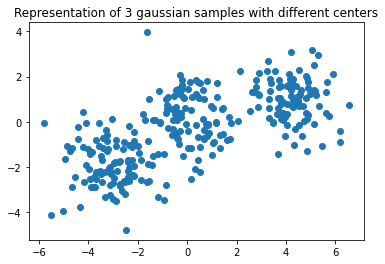

In [7]:
introduction()

Below we present an interactive program that show each step of the k-cluster algorithm. Each color of the points of $X$ is associated with a cluster. In red we represent the centers that we used to compute the clusters and the red hollow circle is the mean of the clusters computed that will become the centers for the next clusters that we will compute. The lines represent the voronoi diagram of the centers. The lines are dotted if one of their side continue to the infinity. The principle is that the voronoi diagram represent the limit where each point will be at the same distance between 2 cluster's center. 

- The variables xlim_inf,xlim_sup,ylim_inf and ylim_sup represent the dimensions of the windows inside which we show the differents clusters.
- The step slider represent the step of the algorithm. The initialisation step is not show in the slider. 
- voro indicate if we want or not to compute the voronoi diagram of the centers.

Let use understand roughly how this works: 

At the first step we see that one cluster(the green one) has taken the 2 sets generated by different normals. At the next step, we see that it will tend to go to the middle between the two normal's centers. Little by little at each steps the green cluster will have less and less points and goes to the left normal. For the 2 points inside the first cluster they will gradually increase their size. The most left-oriented center will tend to go the middle cluster and the other will go the right. 

In [9]:
run_interact()

interactive(children=(FloatText(value=-4.0, description='xlim_inf'), FloatText(value=4.0, description='xlim_su…

# The flaw of the k-means algorithm: 

Now that we better understand how this algorithm works, let's dig futher to see it's limit.

In 2009, Andrea Vattani wrote an article about the complexity of the k-means in the plane where he find a particular case where the algorithm has an exponential time. More precisely, given n and k such that $k=\Theta(n)$, the algorithm takes $2^{\Omega(n)}$. [1]

The algorithm is difficult to explain mathematically so I will explain how intuitively this algorithm is meant to work. Also the algorithm is difficult to illustrate with the interactive program because the graph is too large and there seems to be some computational problem when we want to compute the voronoi diagram of the cluster for large n. Therefore, we will  reuse the diagram used in the article,reexplain with our words how it works and show some intuitive plots about the program.

The principle of this born is to control how the algorithm works to obtain an exponential time algorithm. Let $t$ be an integer. For this algorithm we will call $W_i$ for $i=0,...,t-1$ a watchman(which correspond to a set of point). Each watchman works in cycles of 3 step(morning, afternoon and night). 

- For $i>0$ the watchman $W_i$. The watchman is waiting to be awoken by $W_{i+1}$ to begin his 'day' cycle
    - During the morning, $W_i$ check if $W_{i-1}$ is slepping. If yes, he wakes up $W_{i-1}$ and pass to the next step. If no he waits until $W_{i-1}$ sleeps
    - During the afternoon, its the same logic: $W_i$ check if $W_{i-1}$ is slepping. If yes, he wakes up $W_{i-1}$ and pass to the next step. If no he waits until $W_{i-1}$ sleeps.
    - During the night, $W_i$ goes into sleep.

The figure 1 below illustrate this concept

- For $i=0$, the watchman has a two step cycle. If he is woken up, he stay awake one cycle and after it sleeps.


In [ ]:
img = cv2.imread(r'images/watchers.jpg') 
cv2_imshow(img) 

## Transposition to the algorithm

In the algorithm, each watchman $W_i, \; i>0$ correspond to a gadget $G_i$ which is a tuple $(\mathcal{P_i},T_i,r_i,R_i)$ where $\mathcal{P_i}$ is a set of seven weighted points $\{P_i,Q_i,A_i,B_i,C_i,D_i,E_i\}$ in the $\mathbb{R}^2$ space. $r_i$ and $R_i$ are the inner and outer radious which are tools to ease the mathematical construction of the algorithm. $T_i$ is the position of the centers at initialisation. Let us call $S_i^*$ the center of mass of the points $\{A_i,B_i,C_i,D_i\}$. We say that one gadget "falls asleep" when one center of the gadjet touches the point $S_i^*$.

The lead Gadget $G_0$ correspond just to a point $P_0= \{F\}$ and one center $ |T_0|=1 $. We say also that $S_0^*=F$.

The algorithms is prouved to work with any initialisation that takes points among the dataset. 

Now we will explain with the figure of the article[1] that shows how the algorithm works for a typical gadget such that $i>0$. 

The figure 2 show the days of a gadget. 
The figure 3 show how a gadget is woken up.

There figure are used two compute the graph below that say at witch step is the gadget. There is 7 steps in the cycle of a gadget $G_i$: 

- The Morning: it waits that $G_{i-1}$ sleeps
- 1st Call: wake up $G_{i-1}$ a first time. This call last two steps. 
- The Afternoon: it waits that $G_{i-1}$ sleeps
- 2nd Call: same things that the 1st Call.
- The Night: $G_i$ sleeps

When $i=0$ there is just 2 step: Morning and Night. 

In [ ]:
img = cv2.imread(r'images/day_gadget.jpg') 
cv2_imshow(img) 

In [ ]:
img = cv2.imread(r'images/wake_up.jpg') 
cv2_imshow(img) 

To better understand the synergy between the differents gadgets the two graphs belows show each state of each gadgets during the differents steps of the k-means:

We can have a first understanding of the algorithm by looking at "Who is sleeping?" graph below. We see that when the last gadget $G_3$ sleeps there is no ones to wakes him up so he will always sleep. By induction we deduce that all the gadgets will sleep after some times.

The second graph show the cycle of the gadgets. We see that each one of them follow the cycle precisely and wakes up the other gadget two times before sleeping. There is also a waiting processes before moving to the next step.

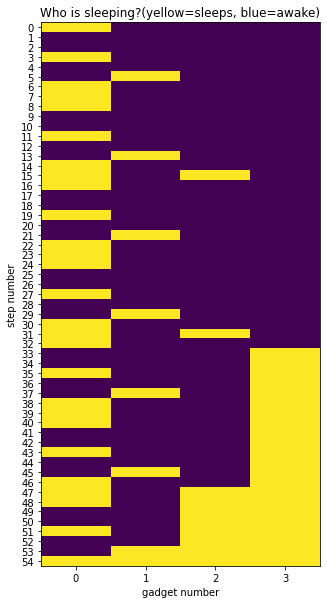

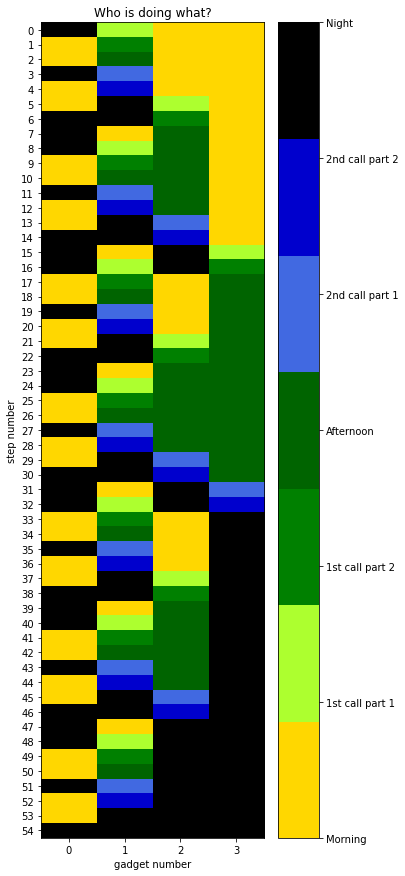

In [9]:
show_state()

## Supplementary informations about the algorithm

The algorithm works with weighted points. But it is prouven that it can works with non-weigthed points. Indeed it is prouved in the article[1] that during each step none of the points of the algorithm is never at equals distance of 2 clusters. Below I explain how we can convert each points into a non-weighted points set:

1. We find a circle around each of those points that are never intersected by the lines of the voronoi diagram.(using property explained just above)
2. We place a number of new points inside this circle such that this numbers equals the weight of the initial point and their center is a the position of the initial weighted point.

By induction by the step of the algorithm in increasing order we see that the new means and clusters and identics. 

# The graphical interface

To give a better understading of the k-means algorithm I created an interactive interface which represent each clusters by one color, shows the mean of the cluster and shows the 'center' of the cluster. The centers represent the set of points $c_i \; \forall i\in\{1,...,n\}$ from which we compute the current clusters. The mean of the cluster represent where the next cluster $c_{i+1}$ will be located. 

To better understand how to centers are computed, we add a voronoï diagram of the centers. Each faces of the voronoï diagram represent a set where all the points inside it belongs to the same cluster. 

## Compute the Voronoi graph

### How to draw the voronoi lines

To better understand where the points will be separated between clusters, we do a Voronoi diagram of the centers. To do this we use the scipy function Voronoi diagram: scipy.spatial.Voronoi but this function is not easy to use because it will return for each segment of the voronoi diagram the two points of the voronoi diagram that delimit the segment and the 2 centers that was used to compute it. But there is a case where the segment is a ray, let's call it $R$, that goes to the infinity and the scipy function return the starting point of the ray and we need to find it's direction from the 2 centers associated. 

Let $c_1$ and $c_2$ be the 2 centers mentionned before. To compute the ray, we need to understand that it is included inside the line $L$ where $x\in L \iff d(c_1,x)=d(c_2,x)$. We see that the perdendicular of the vector $c_2 - c_1$ and passing by the middle of the two points $(c_1+c_2)/2$ correspond to this line. 

Now the difficult part is to find the direction of the line. To do this we need to understand that there should be no centers in the half-plan delimited by the line passing by $c_2$ and $c_1$ and in the direction such that it insect $R$ at the infinity(or we can say that the length of the intersection of the half-plan and R has an infinite length). Indeed, let prove it by contradiction; if there is a center $c$ that is stricly inside this plan, we define $c_p$ the point between $c_1$ and $c_2$ that is the nearest of $c$. We will draw the line where the points are at equal distance between $c$ and $c_p$. This line must intersect the ray at some point. If we continue further in the direction of the ray, the point will be stricly closer to $c$ that $c_p$ and we arrive at a contradiction because by definition this line must have $c_1$ and $c_2$ as the closest clusters. The graph below show an example to illustrate this point. 


In [23]:
img = cv2.imread(r'images/img_1.jpg')
cv2_imshow(img) 

NameError: name 'cv2_imshow' is not defined

In practice to see if the first perpendicular direction that we compute is good we check for one center $c$ if the angle between the ray vector $r$ and $c-m$ is larger or smaller than 90° as show in the pseudo-code below. The $prec$ variable serve to eliminate the cases where the angle is near 90° and he risk to generate some computationnal errors. In this cases, We check another point in the list of the centers.  

    r = perpendicular(c_1,c_2)
    m = (c_1+c_2)/2
    prec = 1e-10
    for c in centers: 
        if( dot_product(c-m,r) > prec ):
            dir_lin *= -1
            break
        elif( dot_product(c-m,r) < prec ):
            dir_lin *= 1
            break
                 
                 
Now we need to see where is the limit of our line. Before explaining the topic, let's explain how matplotlib work to draw a segment in 2D. It is a function that takes two set points, one for the x axis($X$) and another for the y axis($Y$) and plot each tuple in 2D space containing the $i^e$ of X and Y and links them with a segment. 

We want to plot the line inside the square defined by $[x\_lim[0],x\_lim[1]]\; \times \; [y\_lim[0],y\_lim[1]]$. To do this we need to find the intersection of the ray with the cube. To do this we compute the intersections points of the ray with the square segment by segment in 2 step where each segment contain 2 corners of the cube.

step 1: We check if the ray touches the segment of cube with the code that we have seen in the exercice session. 
step 2: We compute mathematically the formula of the intersection between 2 lines. 

If the point is inside the square(checked with the technique seen in the exercice sessions) we have the limit point of our ray which is where an intersection with a segment happend.

If the point is outside the square. If we find 2 differents points of intersections we draw the line. Otherwise we do nothing because the line doesn't go inside the square. 



## The definition of the colorpalette

To have a nice graphical representation, we need to have a good colorpalette representing the differents clusters

To do that 2 ideas where tested: 

The first one consist to divide the light's spectrum in a serie of point at equal distance(in wavelength basis) between each other: 

In [ ]:
img = cv2.imread(r'images/img_2.jpg')
cv2_imshow(img) 

When we have lot's of clusters the colors are beginning to ressemble to each others.

In [ ]:
img = cv2.imread(r'images/img_3.jpg')
cv2_imshow(img) 

The other solution in to use seaborn color system which optimize the hue to better distinguish the points. According to https://www.merriam-webster.com/dictionary/hue, the hue is "the attribute of colors that permits them to be classed as red, yellow, green, blue, or an intermediate between any contiguous pair of these colors". 

To implement it we use the sns library. 

Below you can see the application of the new color-palette on the dataset. In the second graph there is still color that resemble each-others but it seems better than the previous ones. 

In [ ]:
img = cv2.imread(r'images/img_4.jpg')
cv2_imshow(img) 
img = cv2.imread(r'images/img_5.jpg')
cv2_imshow(img) 

# References

In [ ]:
img = cv2.imread(r'images/ref.jpg')
cv2_imshow(img) 